## For the full guide go to https://github.com/fizyr/keras-retinanet

In [6]:
import os
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
import os
import pandas as pd
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

from keras_retinanet.models import load_model


import keras
def rename_path(train_path):
    for folder in [train_path]:
        print(folder)
        for file_name in os.listdir(folder):
            new_file_nm = os.path.join(file_name.replace(',', ''))
            os.rename(os.path.join(folder, file_name), os.path.join(folder, new_file_nm))
rename_path('./images')

Using TensorFlow backend.


./images


In [5]:
# desired input path, x_min, y_min, x_max, y_max
train = pd.read_csv('annotation.csv', header=None)
train.head()

0     1    2     3    4      5
0  42.96512  47.51175_35.jpg   802  665   905  741  total
1  42.96512  47.51175_35.jpg  1758  917  1791  949  total
2   43.04358  44.62776_1.jpg  1064  826  1131  885  total
3   43.04358  44.62776_1.jpg   172  282   297  408  total
4   43.04358  44.62776_1.jpg   246  212   363  328  total

In [17]:
!python train.py --weights ./snapshots/resnet50_csv_13_basem_0_3092_ground_0_2068.h5 --backbone resnet50 --image-min-side 800 --image-max-side 1600 --random-transform --batch-size 2 --steps 500 --epochs 50 --compute-val-loss   csv ./images/annotation_train_1_class.csv classes_total.csv --val-annotations ./images/annotation_test_1_class.csv

Using TensorFlow backend.
W1204 22:56:04.427549 140336449554240 deprecation_wrapper.py:119] From train.py:66: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1204 22:56:04.427735 140336449554240 deprecation_wrapper.py:119] From train.py:68: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-12-04 22:56:04.437809: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-12-04 22:56:04.461158: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3193530000 Hz
2019-12-04 22:56:04.462235: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558031a22190 executing computations on platform Host. Devices:
2019-12-04 22:56:04.462295: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-12-04 22:56:04.463607: I tensorflow/stream_ex

2019-12-04 22:56:26.310655: W tensorflow/core/common_runtime/bfc_allocator.cc:237] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2019-12-04 22:56:26.311807: W tensorflow/core/common_runtime/bfc_allocator.cc:237] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2019-12-04 22:56:26.328720: W tensorflow/core/common_runtime/bfc_allocator.cc:237] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2019-12-04 22:56:26.328804: W tensorflow/core/common_runtime/bfc_allocator.cc:237] Alloc

In [11]:
def nms_cpu(boxes,  _scores, overlap_threshold=0.1, min_mode=False):
    boxes = boxes#.cpu().numpy()
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = _scores#np.array(list(range(len(boxes)))) #boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        keep.append(order[0])
        xx1 = np.maximum(x1[order[0]], x1[order[1:]])
        yy1 = np.maximum(y1[order[0]], y1[order[1:]])
        xx2 = np.minimum(x2[order[0]], x2[order[1:]])
        yy2 = np.minimum(y2[order[0]], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if min_mode:
            ovr = inter / np.minimum(areas[order[0]], areas[order[1:]])
        else:
            ovr = inter / (areas[order[0]] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

def draw_caption(image, box, caption):
    """ Draws a caption above the box in an image.
    # Arguments
        image   : The image to draw on.
        box     : A list of 4 elements (x1, y1, x2, y2).
        caption : String containing the text to draw.
    """
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 1)

In [19]:
model = models.load_model('/home/dex/Desktop/ml/multilabel retinanet/snapshots/resnet50_csv_04_0_3799_all.h5', backbone_name='resnet50')
model = models.convert_model(model)

processing time:  0.16106367111206055


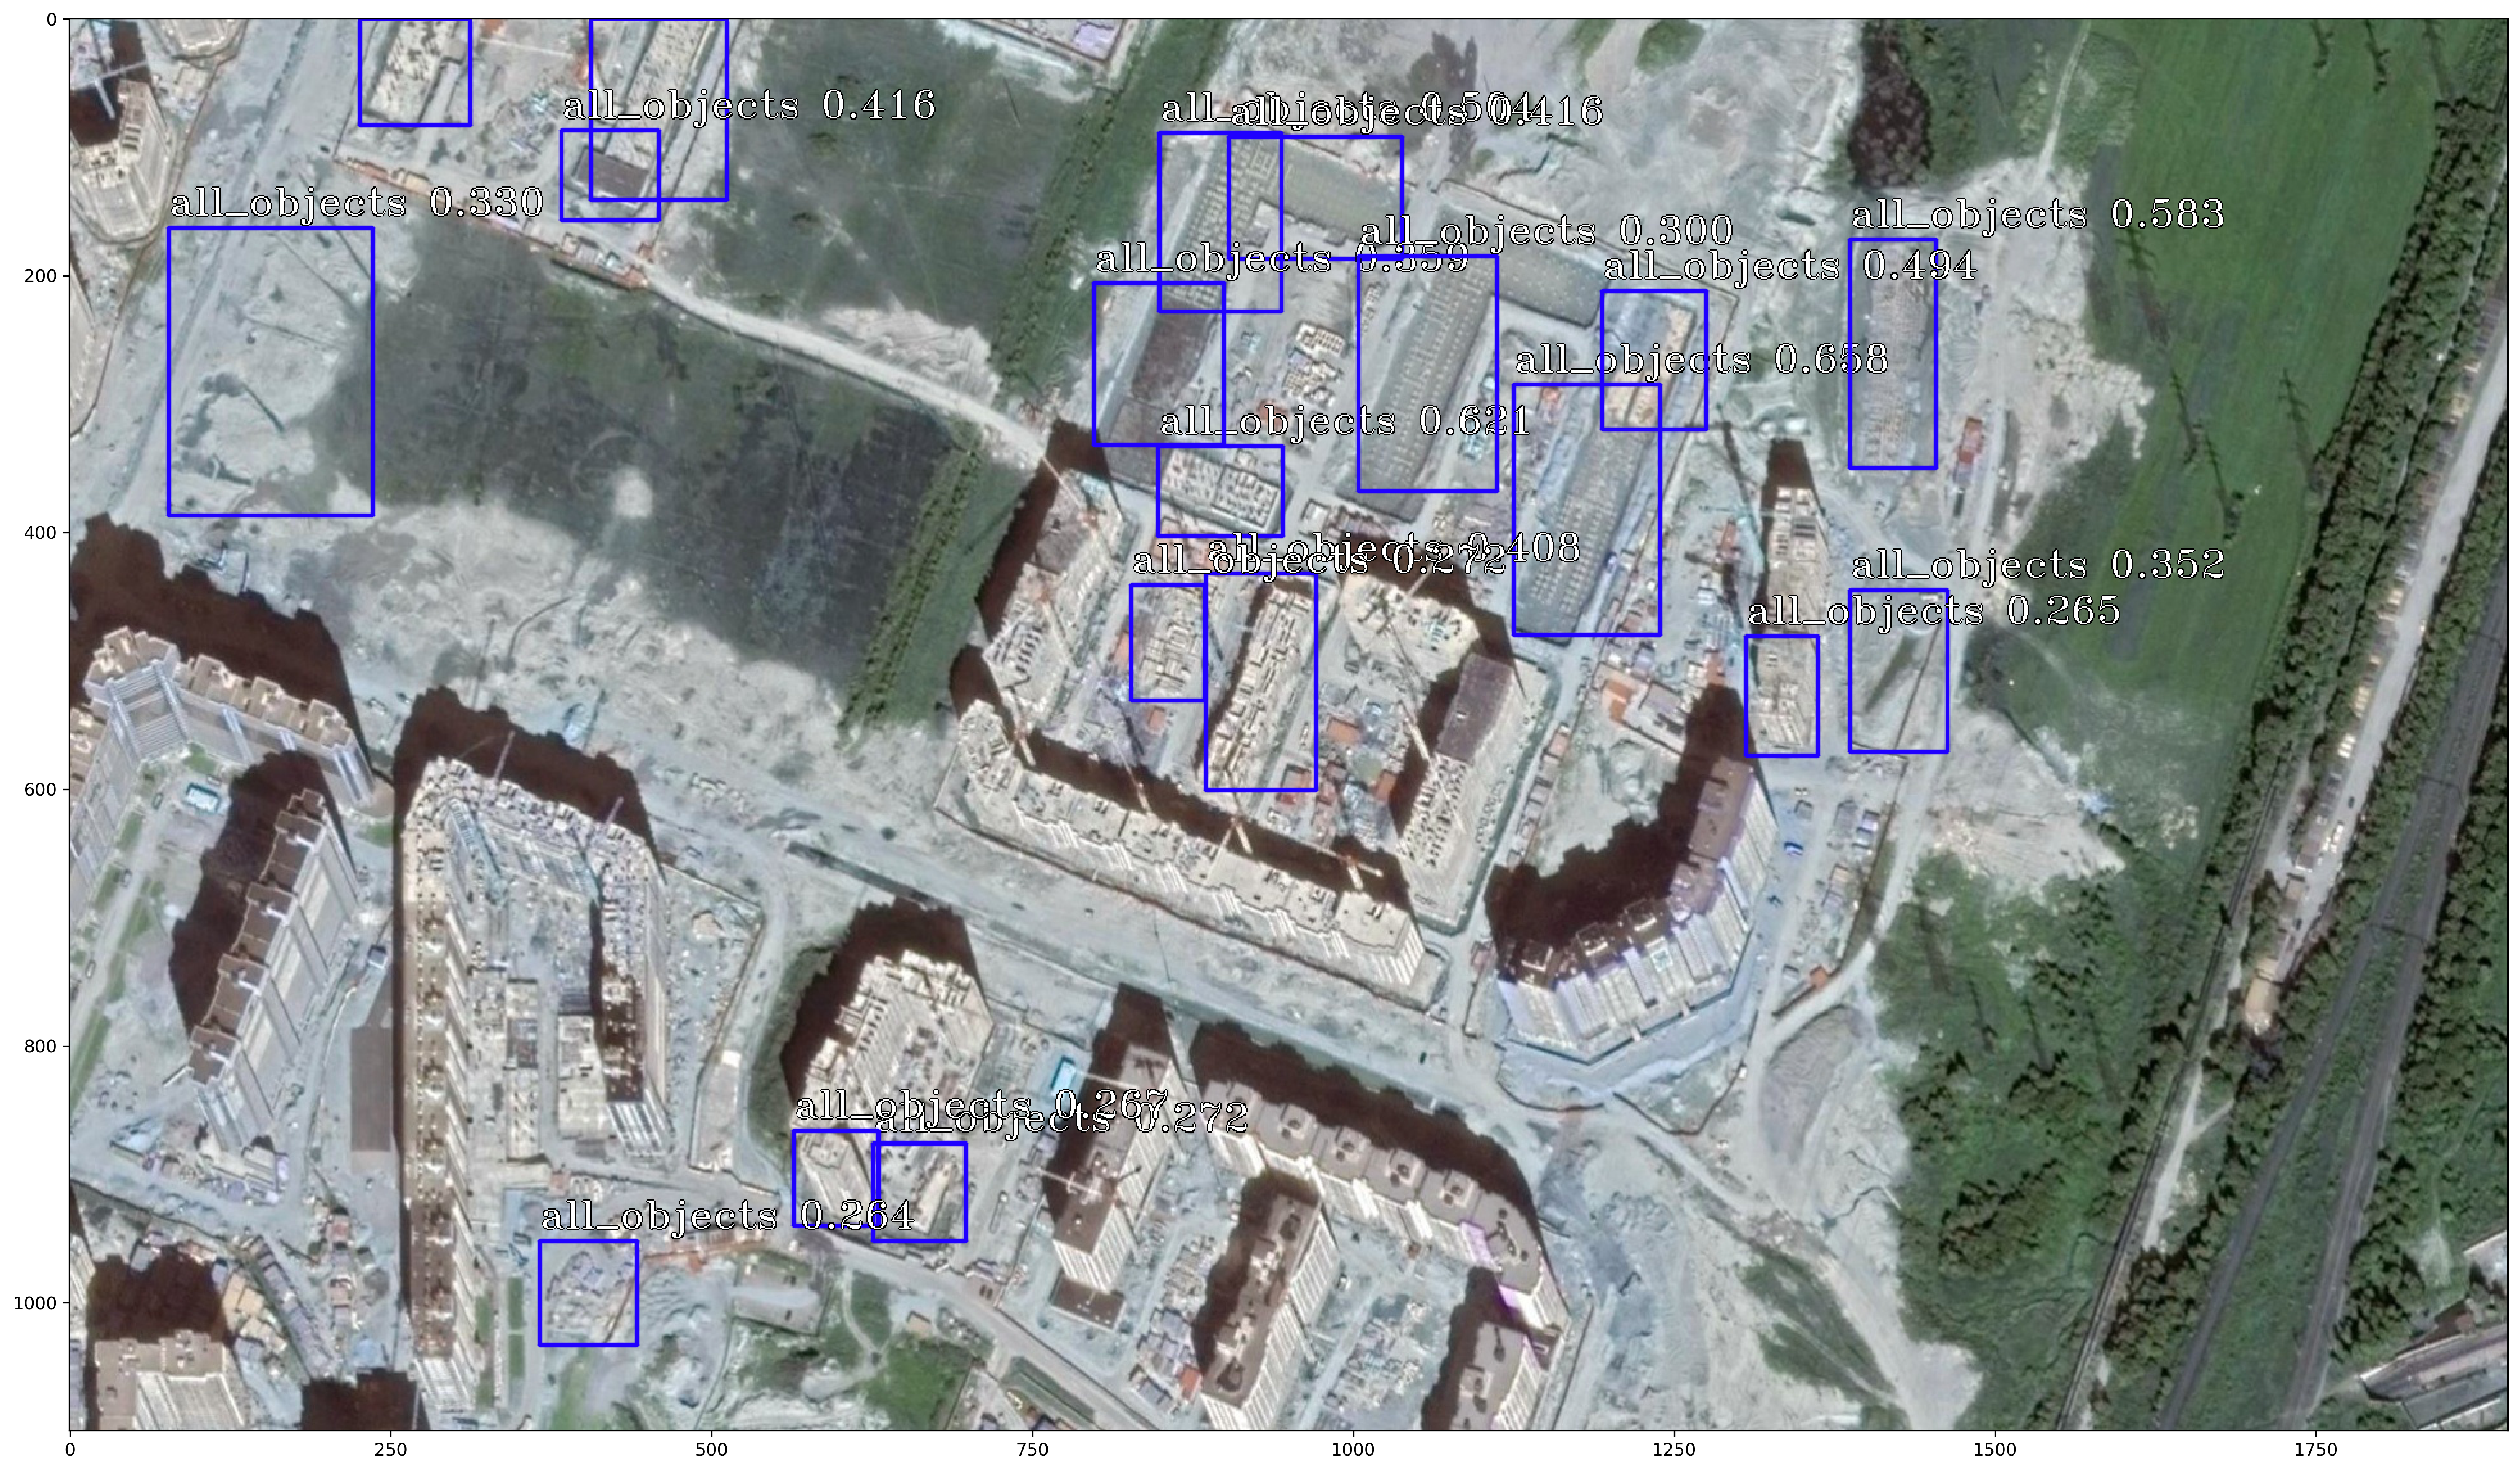

In [22]:
# TRAIN
#labels_to_names = {0:'house',1:'karkas',2:'groud'}
labels_to_names = {0:'all_objects'}

image = read_image_bgr('./images/images.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image, min_side=800, max_side=1600)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

keep_id = (nms_cpu(boxes[0],  scores[0], overlap_threshold=0.2, min_mode=False))
boxes_nms = np.array(boxes[0])[keep_id]
scores_nms = np.array(scores[0])[keep_id]

# visualize detections
for box, score, label in zip(boxes_nms, scores_nms, labels[0]):
    # scores are sorted so we can break
    if score < 0.25:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)#"{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(25, 25), dpi=300)
#plt.savefig('output.png', dpi=300)
plt.imshow(draw)
plt.show()